# Getting Started with Landsat

This notebook is a very simple example of the fundamentals of working with
Earth observation data using the Open Data Cube.

## Import libraries

In [1]:
import os

from datacube import Datacube
from datacube.utils.aws import configure_s3_access
from odc.geo.geom import point
from piksel.utils import patch_usgs_landsat

## Configure the environment

In [2]:
# os.environ['AWS_VIRTUAL_HOSTING'] = 'FALSE'
os.environ['AWS_S3_ENDPOINT'] = 's3.us-west-2.amazonaws.com'
os.environ['AWS_DEFAULT_REGION'] = 'us-west-2'

del os.environ["AWS_NO_SIGN_REQUEST"]

configure_s3_access(requester_pays=True)

dc = Datacube()

## Pick a study area

In [4]:
# Find a location you're interested in on Google Maps and copy the coordinates
# by right-clicking on the map and clicking the coordinates

# These coords are in the order Y then X, or Latitude then Longitude
coords = -8.6252, 115.2048  # Denpasar, Bali
aoi_point = point(coords[1], coords[0], crs="EPSG:4326")
bbox = aoi_point.buffer(0.2).boundingbox

landsat_stretch = dict(vmin=7500, vmax=12000)

datetime = "2025-03"

# Preview the area
bbox.explore(zoom=8)

## Load data

This uses the Datacube library to handle loading of the actual data. The `dask_chunks` argument instructs the tool to use Dask
to lazy-load the data.

In [5]:
data = dc.load(
    product="ls9_c2l2_sr",
    measurements=["red", "green", "blue"],
    output_crs="EPSG:32750",
    resolution=30,
    time=datetime,
    longitude=(bbox.left, bbox.right),
    latitude=(bbox.bottom, bbox.top),
    dask_chunks={"time": 1, "x": 512, "y": 512},
    group_by="solar_day",
    patch_url=patch_usgs_landsat
)

data

Querying product Product(name='ls9_c2l2_sr', id_=1)


<xarray.Dataset> Size: 52MB
Dimensions:      (time: 4, y: 1482, x: 1475)
Coordinates:
  * time         (time) datetime64[ns] 32B 2025-03-01T02:23:51.539595 ... 202...
  * y            (y) float64 12kB 9.068e+06 9.068e+06 ... 9.024e+06 9.024e+06
  * x            (x) float64 12kB 2.803e+05 2.804e+05 ... 3.245e+05 3.246e+05
    spatial_ref  int32 4B 32750
Data variables:
    red          (time, y, x) uint16 17MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    green        (time, y, x) uint16 17MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    blue         (time, y, x) uint16 17MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes:
    crs:           EPSG:32750
    grid_mapping:  spatial_ref

## Visualise data

This step uses `matplotlib` to view data as a static image. It takes a longer time to
run than previous steps, because it's actually loading the data to prepare the images.

The `to_array()` function is a trick used to be able to visualise the data as a
red, green, blue "true colour" image.

/srv/conda/envs/notebook/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


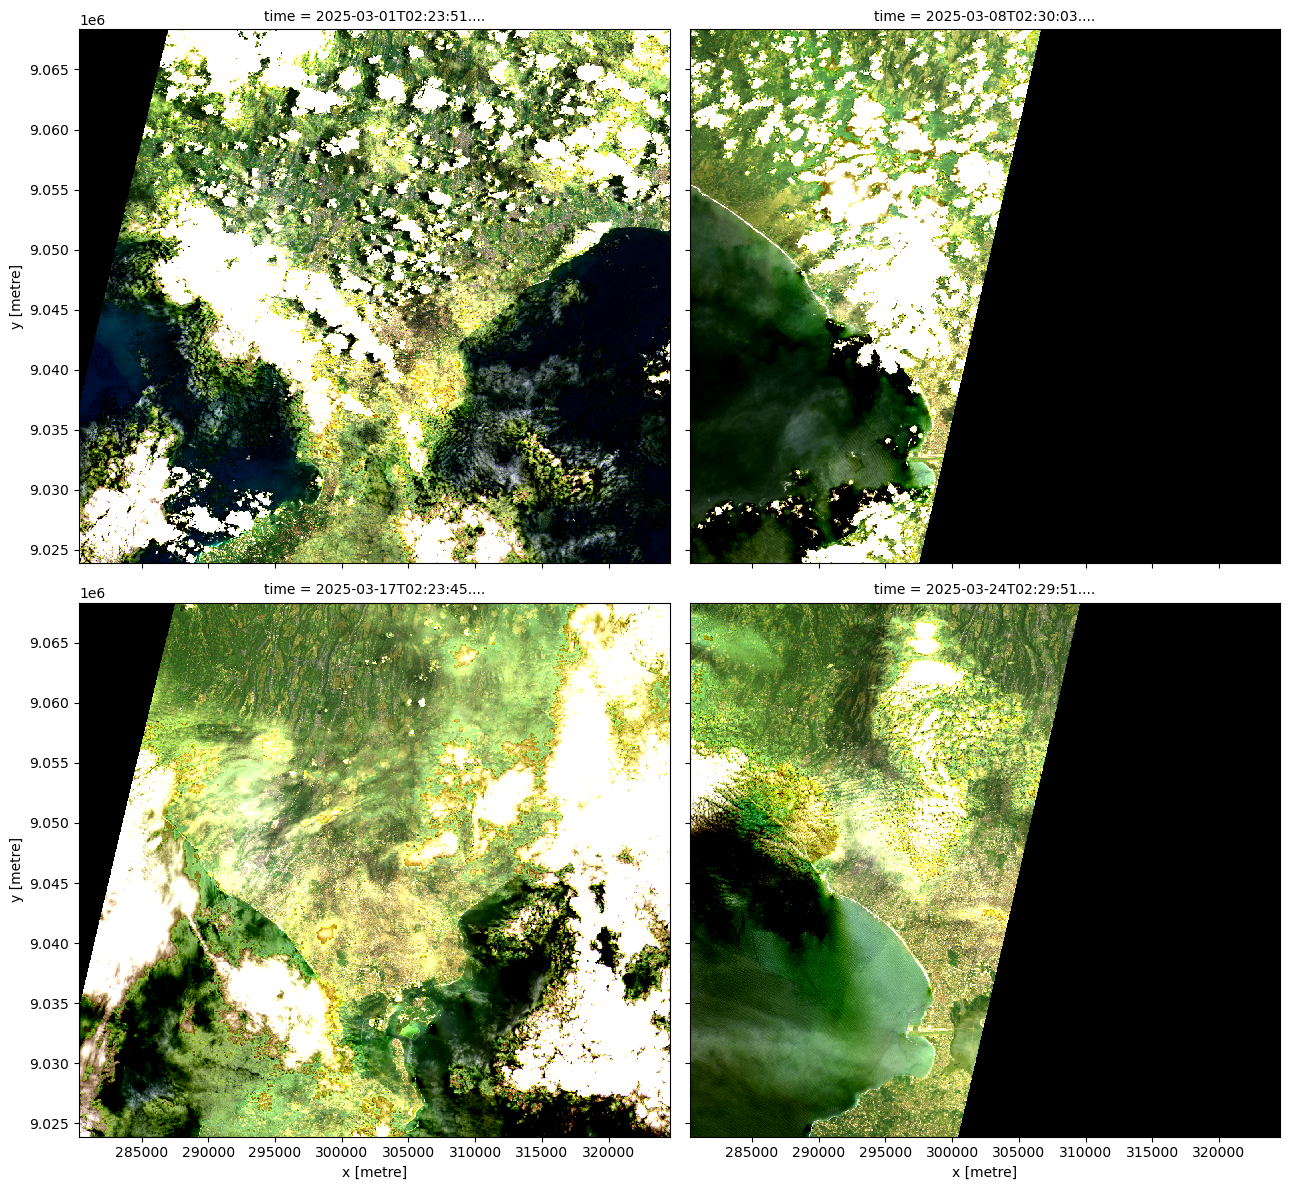

In [6]:
data.to_array().plot.imshow(col="time", col_wrap=2, size=6, **landsat_stretch)

### Interactive map

This step uses another `odc` tool to visualise the data on a map.

In [7]:
best = data.sel(time="2025-03-17").squeeze()

# The odc.explore function will choose red, green and blue by default
# but you can choose bands with the bands=["b1", "b2", "b3"] argument
best.odc.explore(**landsat_stretch)

## Export data

Here we write data to disk, again using an `odc` tool.

In [8]:
rgba = best.odc.to_rgba(**landsat_stretch)
rgba.odc.write_cog("landsat_example.tif", overwrite=True)

PosixPath('landsat_example.tif')